In [55]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from PIL import Image


In [56]:
torch.__version__

'2.1.2'

In [57]:
import torchvision
torchvision.__version__

'0.16.2'

In [58]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])# c standard deviation values commonly used for pre-trained models on imagenet. 

In [59]:
data_transforms = {'train':transforms.Compose([transforms.Resize((224,224)),transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]),
                 'validation':transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalize])}
#Augmentation: the randomaffine transformation is a good choice for data augmentation. you can also consider adding more augmentation techniqurs like rotation and color jittering
# try experimenting with different data augmentation techniques to enhance the models ability to generalize
    

In [60]:
input_path = '/kaggle/input/alien-vs-predator-images/data/'
train_path = input_path +'train'
validation_path = input_path + 'validation'

In [61]:
#from torchvison import data_transforms
image_datasets = {'train':datasets.ImageFolder(input_path + 'train',data_transforms['train']),
                  'validation':datasets.ImageFolder(input_path + 'validation',data_transforms['validation'])}

In [62]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 694
     Root location: /kaggle/input/alien-vs-predator-images/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2), shear=[-10.0, 10.0])
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 200
     Root location: /kaggle/input/alien-vs-predator-images/data/validation
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [63]:
import os
# list the contents of the directory
root_contents = os.listdir('/kaggle/input/alien-vs-predator-images/data/train')
print(root_contents)
# explore the dataset
for root,dirs,files in os.walk('/kaggle/input/alien-vs-predator-images/data/train'):
  print(f'root:{root}, directories: {dirs},files:{files}')

['predator', 'alien']
root:/kaggle/input/alien-vs-predator-images/data/train, directories: ['predator', 'alien'],files:[]
root:/kaggle/input/alien-vs-predator-images/data/train/predator, directories: [],files:['208.jpg', '333.jpg', '45.jpg', '56.jpg', '89.jpg', '20.jpg', '275.jpg', '212.jpg', '239.jpg', '58.jpg', '150.jpg', '6.jpg', '109.jpg', '149.jpg', '187.jpg', '76.jpg', '71.jpg', '342.jpg', '272.jpg', '270.jpg', '182.jpg', '215.jpg', '185.jpg', '243.jpg', '153.jpg', '189.jpg', '143.jpg', '327.jpg', '253.jpg', '343.jpg', '115.jpg', '131.jpg', '5.jpg', '151.jpg', '8.jpg', '260.jpg', '202.jpg', '84.jpg', '237.jpg', '273.jpg', '286.jpg', '283.jpg', '85.jpg', '67.jpg', '265.jpg', '289.jpg', '118.jpg', '82.jpg', '295.jpg', '176.jpg', '279.jpg', '30.jpg', '97.jpg', '334.jpg', '106.jpg', '163.jpg', '113.jpg', '160.jpg', '38.jpg', '328.jpg', '211.jpg', '42.jpg', '291.jpg', '197.jpg', '33.jpg', '10.jpg', '234.jpg', '178.jpg', '54.jpg', '271.jpg', '251.jpg', '0.jpg', '130.jpg', '62.jpg', '27

In [64]:
train_dataloader = DataLoader(image_datasets['train'],batch_size=32,shuffle=True,num_workers=0)
validation_dataloader = DataLoader(image_datasets['validation'],batch_size=32,shuffle=False,num_workers=0)

In [65]:
for x,y in validation_dataloader: #image - color image shape(batch_size,number of channel,length,width)
     print(x.shape)           # image - black and white image - number of channels is 1
     print(y.shape)
     break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [67]:
import torchvision.models as models
# load resnet model with pre-trained weights
#resnet = models.resnet50(weights='imagenet')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False # making the pretrained model not to update that y false
model.fc = nn.Sequential(
           nn.Linear(2048, 128),
           nn.ReLU(inplace=True),
           nn.Linear(128,2)).to(device)   

In [68]:
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # considering using a learning rate scheduler to adjust the learning rate during training. it can help converge faster and achieve better accuracy

In [69]:
# steps in GD : BATCH of the input/pass it to the model/compute loss function/update the weights

def train(dataloader,model,loss_fn,optimizer):
    model.train() # putting the model in the training mode
    for batch,(x,y) in enumerate(dataloader):
        x = x.to(device)  # sending the data to gpu
        y = y.to(device)
   
    pred = model(x)  # compute predictions
    
    loss = loss_fn(pred,y) # compute loss
    
    # back propagation
    loss.backward() # Wnew = Wold - lr*dl/dw
    optimizer.step()
    scheduler.step()# ou would then update the learning rate in your training loop
    optimizer.zero_grad()
    
    if batch %100 ==0:
        print(f'Loss of the model {loss.item()}')

### def train(dataloader,model,loss_fn,optimizer):
    model.train() # putting the model in the training mode
    for batch,(x,y) in enumerate(dataloader):
        x = x.to(device)  # sending the data to gpu
        y = y.to(device)
   
    pred = model(x)  # compute predictions
    
    loss = loss_fn(pred,y) # compute loss
    
    # back propagation
    loss.backward() # Wnew = Wold - lr*dl/dw
    optimizer.step()
    scheduler.step()# ou would then update the learning rate in your training loop
    optimizer.zero_grad()
    
    if batch %100 ==0:
        print(f'Loss of the model {loss.item()}')
    

In [70]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss, correct

In [71]:
epochs = 5
for t in range(5):
    print(f'Epoch {t+1}')
    train(train_dataloader,model,loss_fn,optimizer)
    test(validation_dataloader,model,loss_fn)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


In [75]:
# ensure that the paths to the validation imges are correct
validation_img_paths = ["validation/alien/21.jpg",
                        "validation/alien/31.jpg",
                        "validation/predator/21.jpg"]

In [76]:
# load images and apply transformations
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]
validation_batch = torch.stack([data_transforms['validation'](img).to(device) for img in img_list])

In [77]:
# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 0.4969, -1.0350],
        [ 0.4173, -1.2020],
        [ 0.0554, -0.4495]], device='cuda:0')

In [78]:
# calculate probabilities and convert to numpy array
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.8222875 , 0.17771246],
       [0.83470213, 0.16529787],
       [0.62359375, 0.37640625]], dtype=float32)

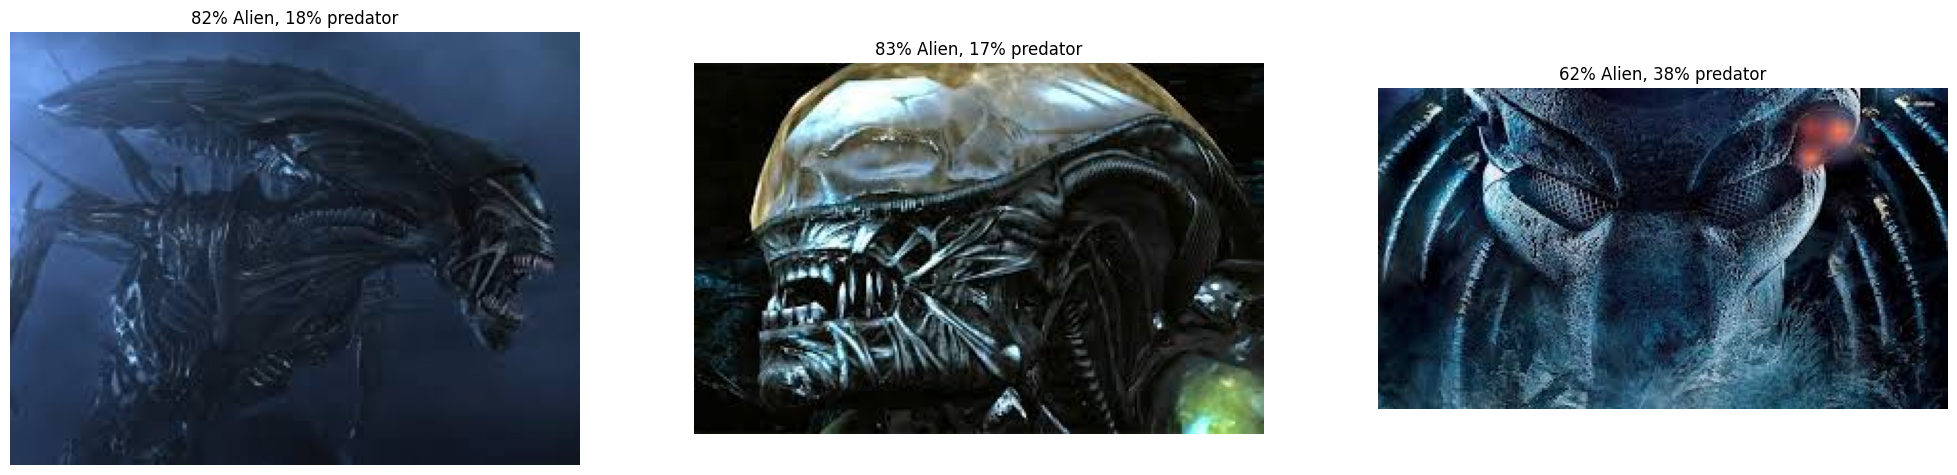

In [82]:
# visualize results
fig,axs = plt.subplots(1, len(img_list), figsize=(25,8))
for i ,img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% predator". format(100*pred_probs[i,0],100*pred_probs[i,1]))
    ax.imshow(img)
plt.show()